In [1]:
import os
import datetime
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/rl_sim/TactileDriven_Arto/UTILITIES')

from Performance_plotter import plot_f1_score_threshold, plot_precision_recall_curve, plot_confusion_matrix, plot_roc_curve
from ML_models_functions import to_save_model, free_gpu_memory, save_datasummary_and_results
from XAI_FCN import plot_grad_cam

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from scipy.signal import butter, filtfilt
import traceback

import tensorflow
gpus = tensorflow.config.list_physical_devices('GPU')
# if gpus:    
#     for gpu in gpus:
#         tensorflow.config.set_logical_device_configuration(
#             gpu,
#             [tensorflow.config.LogicalDeviceConfiguration(memory_limit=4*1024)])  # Adjust memory limit as needed


import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    print(gpu)
# Set GPU 1 (the second GPU) to be the only visible device
# if gpus:
#     try:
#         tf.config.set_visible_devices(gpus[1], 'GPU')
        
#         # Optionally, set memory growth to avoid allocating all memory on the GPU at once
#         tf.config.experimental.set_memory_growth(gpus[1], True)
#     except RuntimeError as e:
#         print(e)


from tensorflow.keras.models     import Sequential, Model, load_model
from tensorflow.keras.layers     import Input, Conv1D, Conv2D, BatchNormalization
from tensorflow.keras.layers     import Flatten, Dense, MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D, GlobalMaxPooling2D
from tensorflow.keras.layers     import LeakyReLU, ReLU, Activation, Dropout, Lambda
from tensorflow.keras.layers     import concatenate, Concatenate, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.losses     import BinaryCrossentropy
from tensorflow.keras.metrics    import AUC
from tensorflow.keras.callbacks  import EarlyStopping

from tensorflow.keras.utils      import plot_model

def load_data(data_folder):
    X_data = []
    y_data = []
    
    # Traverse the data folder
    for file in os.listdir(data_folder):
        if file.endswith(".npz"):
            file_path = os.path.join(data_folder, file)
            data = np.load(file_path)
            X_data.append(data['X'])
            y_data.append(data['y'])
    
    # Stack the data into arrays
    X_data = np.vstack(X_data)
    y_data = np.hstack(y_data)
    
    return X_data, y_data


data_folder = '/home/rl_sim/TactileDriven_Arto/ML_Actions/DATA/1D_TRANSF_LDG_FTP_ScalNorm/'

X_data, y_data = load_data(data_folder)

# Check the shape of loaded data
print("X_data shape:", X_data.shape)
print("y_data shape:", y_data.shape)
print("X_data.[0] shape: ", X_data[0].shape)
print("y_data.[0] max: ", np.max(y_data))

TEST_SIZE = 0.4
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size=TEST_SIZE, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"TOTAL DATA: {len(X_data)}  ||  Train = {100*(1-TEST_SIZE)}%  ||  Test = {100*TEST_SIZE}%")
print("Dimensions of X_train:", X_train.shape, "   ||  Dimensions of y_train:", y_train.shape)
print("Dimensions of X_test: ", X_test.shape, "   ||  Dimensions of y_test: ", y_test.shape)
print("Dimensions of X_val:  ", X_val.shape, "   ||  Dimensions of y_val:  ", y_val.shape)

data_dict = {
    "X_train": X_train,
    "X_val": X_val,
    "X_test": X_test
}

def assign_and_deploy_variables(data_dict):
    for key, data in data_dict.items():
        globals()[f"{key}1"] = data[:, :, 2]
        globals()[f"{key}2"] = data[:, :, 1]
        globals()[f"{key}3"] = np.dstack((data[:, :, 2], data[:, :, 3]))
        globals()[f"{key}4"] = np.dstack((data[:, :, 6], data[:, :, 8]))

import tensorflow as tf

WS_B = 3000  # Example sequence length
input_shape1 = (WS_B, 1)
input_shape2 = (WS_B, 1)
input_shape3 = (WS_B, 2)
input_shape4 = (WS_B, 2)

assign_and_deploy_variables(data_dict)

# Printing shapes
print("Shapes of the stacked arrays:")
print("X_train1 shape:", X_train1.shape)
print("X_train2 shape:", X_train2.shape)
print("X_train3 shape:", X_train3.shape)
print("X_train4 shape:", X_train4.shape)

OUT_N = int(np.max(y_data)) + 1  # Plus one because labels are typically zero-indexed
DISP_LABELS = list(range(OUT_N))  # Generate labels from 0 to OUT_N-1
print("OUT_N:", OUT_N)
print("DISP_LABELS:", DISP_LABELS)

def compile_train_evaluate_plot(model, X_train, y_train, X_val, y_val, X_test, y_test, epochs=50, batch_size=32, patience=8, disp_labels=DISP_LABELS):
    # Compile the model
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                        validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping])

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test)

    # Predict labels for test data
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Plot training history
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    # Plot Loss Value
    axs[0].plot(history.history["loss"], label="loss (Training)")
    axs[0].plot(history.history["val_loss"], label="val_loss")
    axs[0].set_title("Loss Value")
    axs[0].set_xlabel('Epoch')
    axs[0].legend()

    # Plot Accuracy
    axs[1].plot(history.history["accuracy"], label="accuracy")
    axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
    axs[1].set_title("Accuracy")
    axs[1].set_xlabel('Epoch')
    axs[1].legend()
    plt.tight_layout()
    plt.show()

    # Calculate additional metrics
    f1 = f1_score(y_test, y_pred_labels, average='macro') 
    accuracy = accuracy_score(y_test, y_pred_labels)

    print("Test loss:", loss)
    print("Test accuracy:", accuracy)
    print("F1 Score:", f1)
    print("Classification Report:\n", classification_report(y_test, y_pred_labels))

    # Confusion matrix
    conf_mat = confusion_matrix(y_test, y_pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=disp_labels)
    disp.plot(cmap=plt.cm.viridis)  # You can adjust the colormap as needed
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    return history, loss, accuracy, f1, y_pred_labels

2024-10-29 19:59:58.425309: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-29 19:59:58.454135: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-29 19:59:58.879998: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
X_data shape: (430, 3000, 9)
y_data shape: (430,)
X_data.[0] shape:  (3000, 9)
y_data.[0] max:  3.0
TOTAL DATA: 430  ||  Train = 60.0%  ||  Test = 40.0%
Dimensions of X_train: (258, 3000, 9)    ||  Dimensions of y_train: (258,)
Dimensions of X_test:  (86, 3000, 9)    ||  Dimensions of y_test:  (86,)
Dimensions of X_val:   (86, 3000, 9)    ||  Dimensions of y_val:   (86,)
Shapes of the stacked arrays:
X_train1 shape: (258, 3000)
X_train2 shape: (258, 3000)
X_train3 shape: (258, 3000, 2)
X_train4 shape: (258, 3000, 2)
OUT_N: 4
DISP_LABELS: [0, 1, 2, 3]


2024-10-29 19:59:59.207337: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-29 19:59:59.207503: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-29 19:59:59.233234: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# 2 CONV like EASY_F+F

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input1 (InputLayer) │ (None, 3000, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input2 (InputLayer) │ (None, 3000, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input3 (InputLayer) │ (None, 3000, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input4 (InputLayer) │ (None, 3000, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_1 (Conv1D) │ (None, 300, 128)  │      5,248 │ input1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_1 (Conv1D) │ (None, 300, 128)  │      5,248 │ input2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_1 (Conv1D) │ (None, 300, 128)  │     10,368 │ input3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_1 (Conv1D) │ (None, 300, 128)  │     10,368 │ input4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_2 (Conv1D) │ (None, 149, 256)  │    131,328 │ conv1d_1_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_2 (Conv1D) │ (None, 149, 256)  │    131,328 │ conv1d_2_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_2 (Conv1D) │ (None, 149, 256)  │    131,328 │ conv1d_3_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_2 (Conv1D) │ (None, 149, 256)  │    131,328 │ conv1d_4_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_1_1           │ (None, 256)       │          0 │ conv1d_1_2[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_2_1           │ (None, 256)       │          0 │ conv1d_2_2[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_3_1           │ (None, 256)       │          0 │ conv1d_3_2[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_4_1           │ (None, 256)       │          0 │ conv1d_4_2[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 256)       │          0 │ gap1d_1_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_9 (Flatten) │ (None, 256)       │          0 │ gap1d_2_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_10          │ (None, 256)       │          0 │ gap1d_3_1[0][0]   │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_11          │ (None, 256)       │          0 │ gap1d_4_1[0][0]   │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 1024)      │          0 │ flatten_8[0][0],  │
│ (Concatenate)       │                   │            │ flatten_9[0][0],  │
│                     │                   │            │ flatten_10[0][0]

 Total params: 622,404 (2.37 MB)

 Trainable params: 622,404 (2.37 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.3978 - loss: 1.2899 - val_accuracy: 0.4070 - val_loss: 1.1818
Epoch 2/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6009 - loss: 0.9107 - val_accuracy: 0.6628 - val_loss: 0.9194
Epoch 3/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6848 - loss: 0.8179 - val_accuracy: 0.6744 - val_loss: 0.8052
Epoch 4/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7529 - loss: 0.5858 - val_accuracy: 0.7558 - val_loss: 0.6663
Epoch 5/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7858 - loss: 0.5042 - val_accuracy: 0.5814 - val_loss: 0.8816
Epoch 6/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7189 - loss: 0.6433 - val_accuracy: 0.7558 - val_loss: 0.5612
Epoch 7/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8108 - loss: 0.4590 - val_accuracy: 0.7209 - val_loss: 0.7581
Epoch 8/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7925 - loss: 0.4819 - val_accuracy: 0.6512 - val_loss: 0.7945
Epoch 

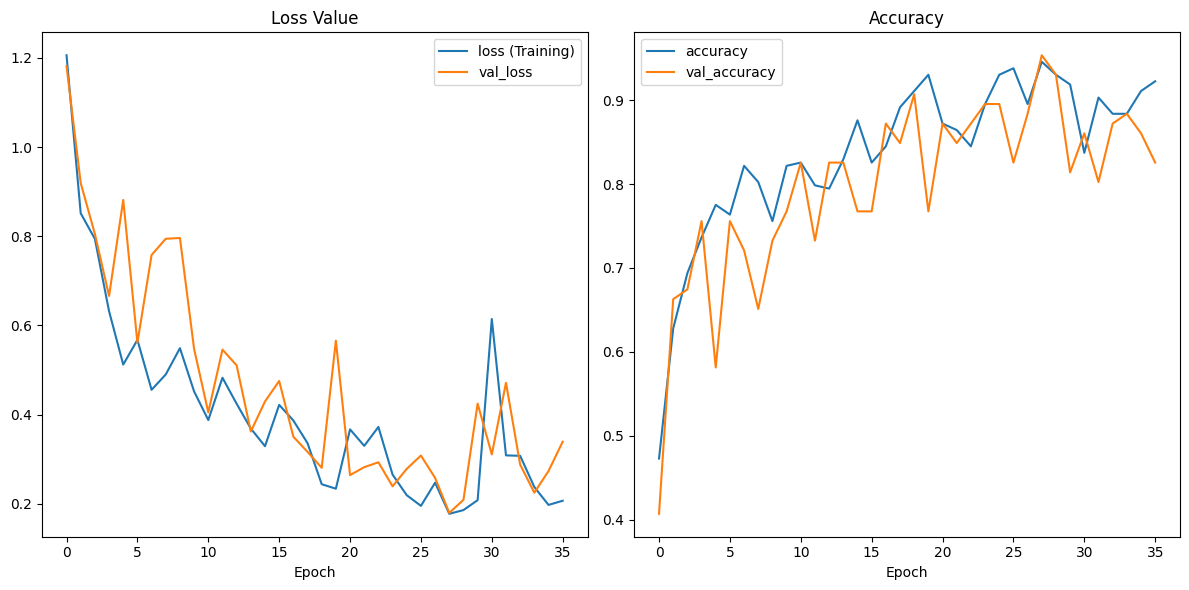

Test loss: 0.15222829580307007
Test accuracy: 0.9767441860465116
F1 Score: 0.978383731541397
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        17
         1.0       1.00      0.96      0.98        25
         2.0       0.92      1.00      0.96        23
         3.0       1.00      0.95      0.98        21

    accuracy                           0.98        86
   macro avg       0.98      0.98      0.98        86
weighted avg       0.98      0.98      0.98        86



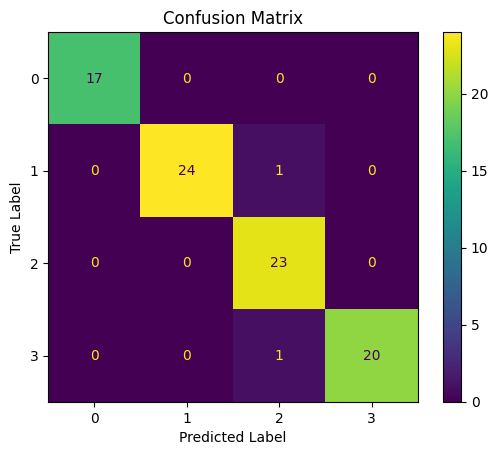

In [7]:
FILTN = 2
def build_branched_model(input_shape1, input_shape2, input_shape3, input_shape4):
    # First input branch
    input1 = Input(shape=input_shape1, name='input1')
    x1 = Conv1D(filters=64*FILTN, kernel_size=40, strides=10, activation='relu', padding='same', name='conv1d_1_1')(input1)
    x1 = Conv1D(filters=128*FILTN, kernel_size=4, strides=2, activation='relu', name='conv1d_1_2')(x1)
    x1 = GlobalMaxPooling1D(name='gap1d_1_1')(x1)
    x1 = Flatten()(x1)
        # it was GlobalAveragePooling1D
    
    # Second input branch
    input2 = Input(shape=input_shape2, name='input2')
    x2 = Conv1D(filters=64*FILTN, kernel_size=40, strides=10, activation='relu', padding='same', name='conv1d_2_1')(input2)
    x2 = Conv1D(filters=128*FILTN, kernel_size=4, strides=2, activation='relu', name='conv1d_2_2')(x2)
    x2 = GlobalMaxPooling1D(name='gap1d_2_1')(x2)
    x2 = Flatten()(x2)
    
    # Third input branch
    input3 = Input(shape=input_shape3, name='input3')
    x3 = Conv1D(filters=64*FILTN, kernel_size=40, strides=10, activation='relu', padding='same', name='conv1d_3_1')(input3)
    x3 = Conv1D(filters=128*FILTN, kernel_size=4, strides=2, activation='relu', name='conv1d_3_2')(x3)
    x3 = GlobalMaxPooling1D(name='gap1d_3_1')(x3)
    x3 = Flatten()(x3)
    
    # Fourth input branch
    input4 = Input(shape=input_shape4, name='input4')
    x4 = Conv1D(filters=64*FILTN, kernel_size=40, strides=10, activation='relu', padding='same', name='conv1d_4_1')(input4)
    x4 = Conv1D(filters=128*FILTN, kernel_size=4, strides=2, activation='relu', name='conv1d_4_2')(x4)
    x4 = GlobalMaxPooling1D(name='gap1d_4_1')(x4)
    x4 = Flatten()(x4)
    
    # Concatenate the outputs of the four branches
    merged = concatenate([x1, x2, x3, x4], name='concatenate_1')
    
    # Dense layers
    dense = Dense(64, activation='relu', name='dense_1')(merged)
    #dense = Dense(16, activation='relu', name='dense_2')(dense)
    
    # Output layer for 6-class classification
    output = Dense(OUT_N, activation='softmax', name='output')(dense)
    
    model = Model(inputs=[input1, input2, input3, input4], outputs=output)
    return model


# Create and compile the model
model = build_branched_model(input_shape1, input_shape2, input_shape3, input_shape4)
model.summary()

X_train = [X_train1, X_train2, X_train3, X_train4]
X_val   = [X_val1, X_val2, X_val3, X_val4]
X_test  = [X_test1, X_test2, X_test3, X_test4]

history, loss, accuracy, f1, y_pred_labels = compile_train_evaluate_plot(model, X_train, y_train, X_val, y_val, X_test, y_test, epochs=70, batch_size=32, patience=8, disp_labels=DISP_LABELS)

In [8]:
# model_name = "1DComb_LDGscal_TRANSF_97"
# save_datasummary_and_results(model, history, loss, accuracy, f1, model_name, y_test, y_pred_labels, build_branched_model, assign_and_deploy_variables)
# #model.save(f"{model_name}.h5")
# from tensorflow.keras.models import save_model
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


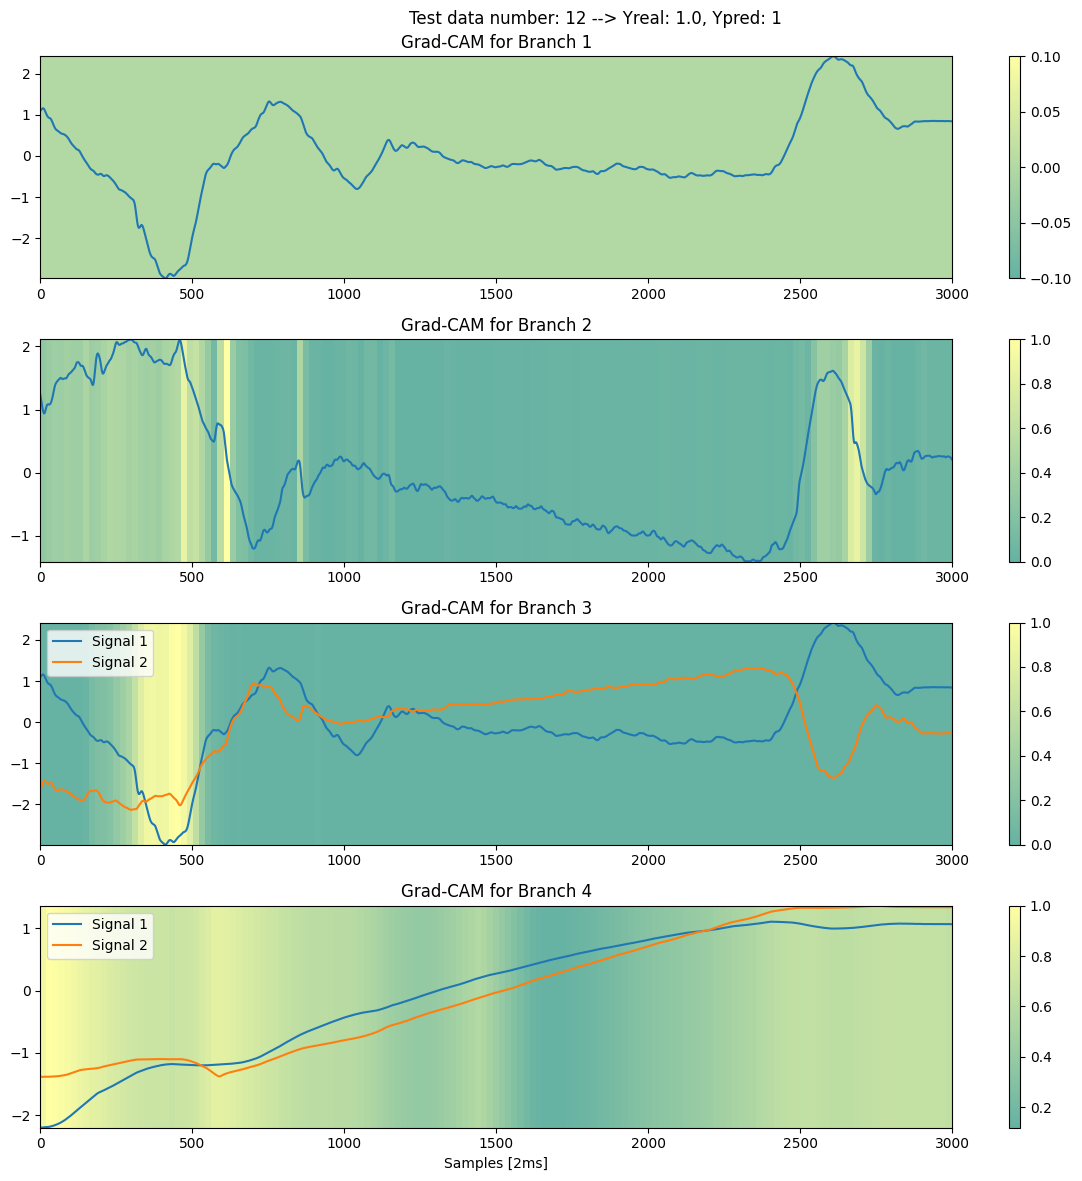

In [9]:
plot_grad_cam(model, [X_test1, X_test2, X_test3, X_test4], 12, y_test, ['conv1d_1_2', 'conv1d_2_2', 'conv1d_3_2', 'conv1d_4_2'])

# 3ConvLayers FirstTry: FxFzTy + Tz + FyTx

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input1 (InputLayer) │ (None, 3000, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input2 (InputLayer) │ (None, 3000, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input3 (InputLayer) │ (None, 3000, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input4 (InputLayer) │ (None, 3000, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_1 (Conv1D) │ (None, 300, 128)  │      5,248 │ input1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_1 (Conv1D) │ (None, 300, 128)  │      5,248 │ input2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_1 (Conv1D) │ (None, 300, 128)  │     10,368 │ input3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_1 (Conv1D) │ (None, 300, 128)  │     10,368 │ input4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_2 (Conv1D) │ (None, 147, 256)  │    262,400 │ conv1d_1_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_2 (Conv1D) │ (None, 147, 256)  │    262,400 │ conv1d_2_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_2 (Conv1D) │ (None, 147, 256)  │    262,400 │ conv1d_3_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_2 (Conv1D) │ (None, 147, 256)  │    262,400 │ conv1d_4_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_3 (Conv1D) │ (None, 146, 512)  │    262,656 │ conv1d_1_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_3 (Conv1D) │ (None, 146, 128)  │     65,664 │ conv1d_2_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_3 (Conv1D) │ (None, 146, 512)  │    262,656 │ conv1d_3_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_3 (Conv1D) │ (None, 146, 128)  │     65,664 │ conv1d_4_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_1_1           │ (None, 512)       │          0 │ conv1d_1_3[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_2_1           │ (None, 128)       │          0 │ conv1d_2_3[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_3_1           │ (None, 512)       │          0 │ conv1d_3_3[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_4_1           │ (None, 128)       │          0 │ conv1d_4_3[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 1280)      │          0 │ gap1d_1_1[0][0],  │
│ (Concatenate)       │                   │            │ gap1d_2_1[0][0],  │
│                     │                   │            │ gap1d_3_1[0][0],  │
│                     │                   │            │ gap1d_4_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,819,716 (6.94 MB)

 Trainable params: 1,819,716 (6.94 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.3410 - loss: 1.3627 - val_accuracy: 0.5465 - val_loss: 1.0583
Epoch 2/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5840 - loss: 0.9951 - val_accuracy: 0.5814 - val_loss: 1.0028
Epoch 3/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6441 - loss: 0.8646 - val_accuracy: 0.6860 - val_loss: 0.8430
Epoch 4/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6722 - loss: 0.7017 - val_accuracy: 0.6512 - val_loss: 0.8849
Epoch 5/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6973 - loss: 0.6645 - val_accuracy: 0.5930 - val_loss: 1.1006
Epoch 6/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6910 - loss: 0.8036 - val_accuracy: 0.6279 - val_loss: 0.8385
Epoch 7/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7267 - loss: 0.6210 - val_accuracy: 0.6977 - val_loss: 0.5671
Epoch 8/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8071 - loss: 0.4995 - val_accuracy: 0.7442 - val_loss: 0.7266
Epoch 9/70
9/9 ━━

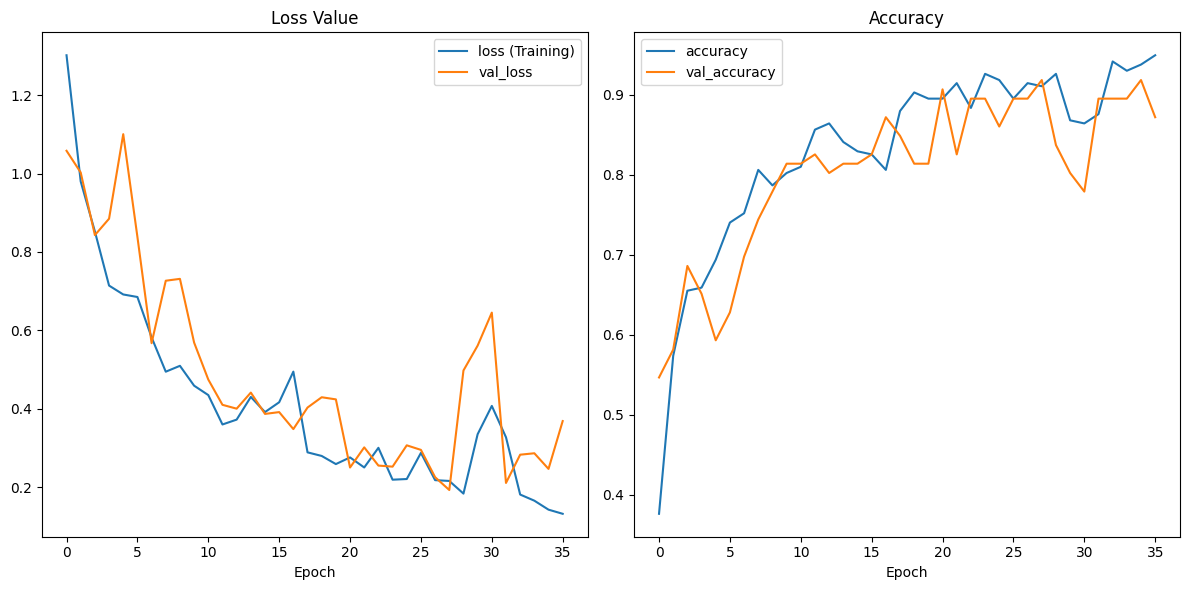

Test loss: 0.16650719940662384
Test accuracy: 0.9534883720930233
F1 Score: 0.954822201607916
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.94      0.97        17
         1.0       1.00      0.96      0.98        25
         2.0       0.85      1.00      0.92        23
         3.0       1.00      0.90      0.95        21

    accuracy                           0.95        86
   macro avg       0.96      0.95      0.95        86
weighted avg       0.96      0.95      0.95        86



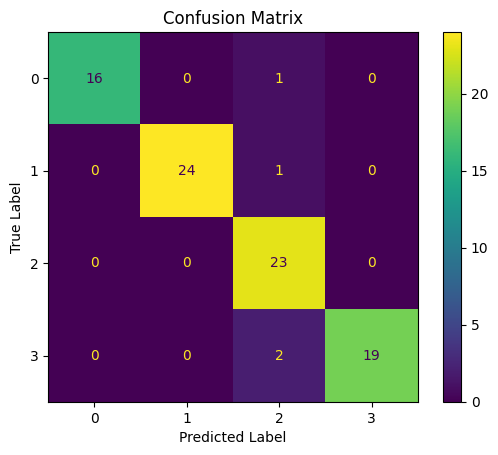

In [5]:
FILTN = 2
def build_branched_model(input_shape1, input_shape2, input_shape3, input_shape4):
    # First input branch
    input1 = Input(shape=input_shape1, name='input1')
    x1 = Conv1D(filters=64*FILTN, kernel_size=40, strides=10, activation='relu', padding='same', name='conv1d_1_1')(input1)
    x1 = Conv1D(filters=128*FILTN, kernel_size=8, strides=2, activation='relu', name='conv1d_1_2')(x1)
    #x1 = Dropout(rate=0.2, name='dropout_1_1')(x1)
    x1 = Conv1D(filters=256*FILTN, kernel_size=2, strides=1, activation='relu', name='conv1d_1_3')(x1)
    x1 = GlobalMaxPooling1D(name='gap1d_1_1')(x1)
    
    # Second input branch
    input2 = Input(shape=input_shape2, name='input2')
    x2 = Conv1D(filters=64*FILTN, kernel_size=40, strides=10, activation='relu', padding='same', name='conv1d_2_1')(input2)
    x2 = Conv1D(filters=128*FILTN, kernel_size=8, strides=2, activation='relu', name='conv1d_2_2')(x2)
    #x2 = Dropout(rate=0.2, name='dropout_2_1')(x2)
    x2 = Conv1D(filters=64*FILTN, kernel_size=2, strides=1, activation='relu', name='conv1d_2_3')(x2)
    x2 = GlobalMaxPooling1D(name='gap1d_2_1')(x2)
    
    # Third input branch
    input3 = Input(shape=input_shape3, name='input3')
    x3 = Conv1D(filters=64*FILTN, kernel_size=40, strides=10, activation='relu', padding='same', name='conv1d_3_1')(input3)
    x3 = Conv1D(filters=128*FILTN, kernel_size=8, strides=2, activation='relu', name='conv1d_3_2')(x3)
    #x3 = Dropout(rate=0.2, name='dropout_3_1')(x3)
    x3 = Conv1D(filters=256*FILTN, kernel_size=2, strides=1, activation='relu', name='conv1d_3_3')(x3)
    x3 = GlobalMaxPooling1D(name='gap1d_3_1')(x3)
    
    # Fourth input branch
    input4 = Input(shape=input_shape4, name='input4')
    x4 = Conv1D(filters=64*FILTN, kernel_size=40, strides=10, activation='relu', padding='same', name='conv1d_4_1')(input4)
    x4 = Conv1D(filters=128*FILTN, kernel_size=8, strides=2, activation='relu', name='conv1d_4_2')(x4)
    #x4 = Dropout(rate=0.2, name='dropout_4_1')(x4)
    x4 = Conv1D(filters=64*FILTN, kernel_size=2, strides=1, activation='relu', name='conv1d_4_3')(x4)
    x4 = GlobalMaxPooling1D(name='gap1d_4_1')(x4)
    
    # Concatenate the outputs of the four branches
    merged = concatenate([x1, x2, x3, x4], name='concatenate_1')
    
    # Dense layers
    dense = Dense(64, activation='relu', name='dense_1')(merged)
    #dense = Dense(16, activation='relu', name='dense_2')(dense)
    
    # Output layer for 6-class classification
    output = Dense(OUT_N, activation='softmax', name='output')(dense)
    
    model = Model(inputs=[input1, input2, input3, input4], outputs=output)
    return model


# Create and compile the model
model = build_branched_model(input_shape1, input_shape2, input_shape3, input_shape4)
model.summary()

X_train = [X_train1, X_train2, X_train3, X_train4]
X_val   = [X_val1, X_val2, X_val3, X_val4]
X_test  = [X_test1, X_test2, X_test3, X_test4]

history, loss, accuracy, f1, y_pred_labels = compile_train_evaluate_plot(model, X_train, y_train, X_val, y_val, X_test, y_test, epochs=70, batch_size=32, patience=8, disp_labels=DISP_LABELS)

In [11]:
# model_name = "MOD_AUG_KNOB_3Cnv_128Dens_400WideKern_96"
# save_datasummary_and_results(model, history, loss, accuracy, f1, model_name, y_test, y_pred_labels, build_branched_model, assign_and_deploy_variables)
# #model.save(f"{model_name}.h5")
# from tensorflow.keras.models import save_model
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


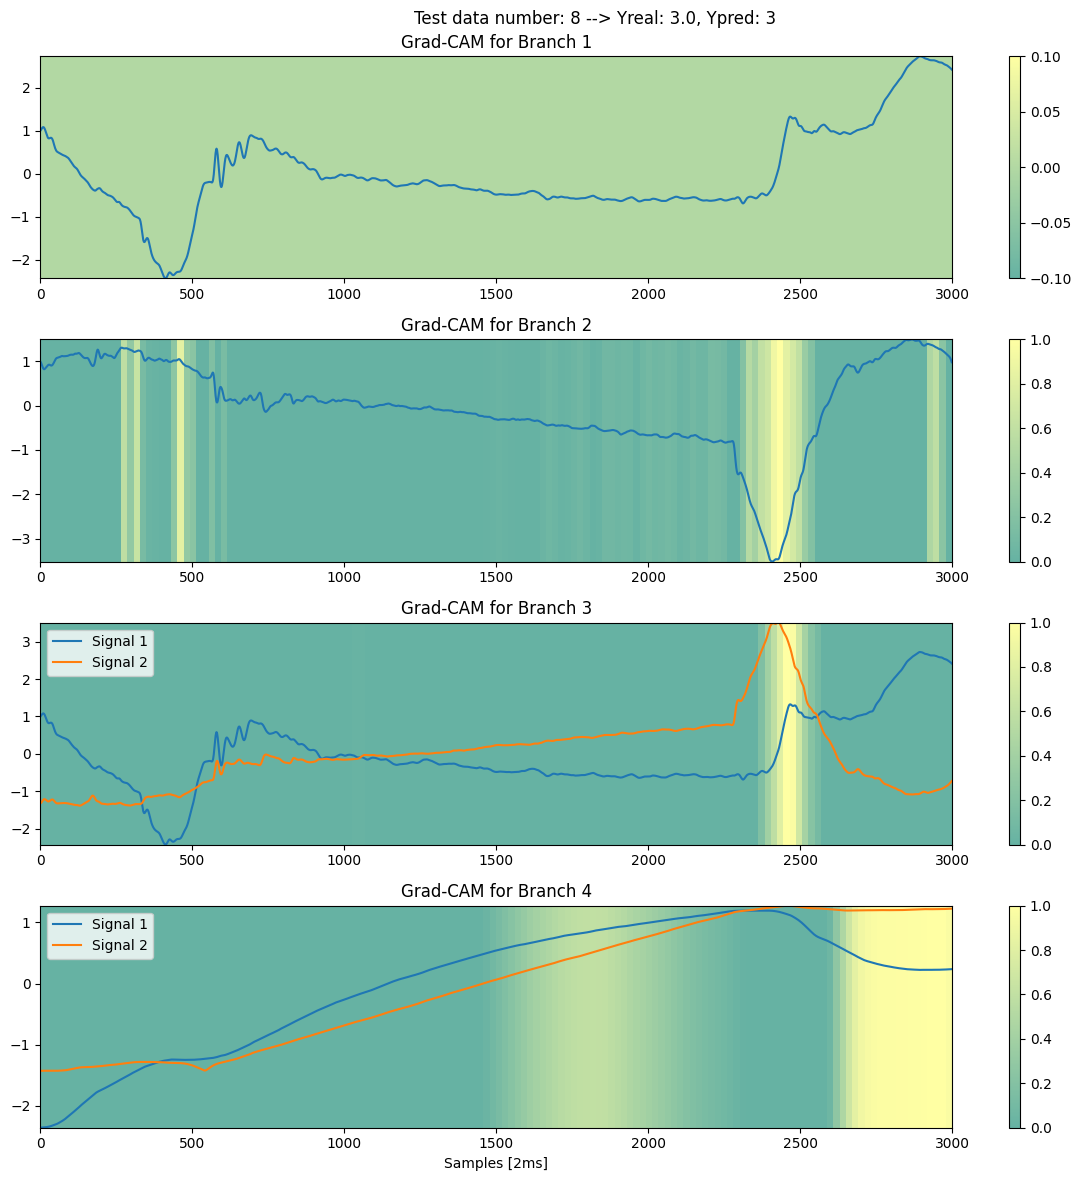

In [12]:
plot_grad_cam(model, [X_test1, X_test2, X_test3, X_test4], 8, y_test, ['conv1d_1_3', 'conv1d_2_3', 'conv1d_3_3', 'conv1d_4_3'])

# 3Conv 93% acheived

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input1 (InputLayer) │ (None, 3000, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input2 (InputLayer) │ (None, 3000, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input3 (InputLayer) │ (None, 3000, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input4 (InputLayer) │ (None, 3000, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_1 (Conv1D) │ (None, 150, 128)  │      5,248 │ input1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_1 (Conv1D) │ (None, 150, 128)  │      5,248 │ input2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_1 (Conv1D) │ (None, 150, 128)  │     10,368 │ input3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_1 (Conv1D) │ (None, 150, 128)  │     10,368 │ input4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maxpool1d_1_1       │ (None, 75, 128)   │          0 │ conv1d_1_1[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maxpool1d_2_1       │ (None, 75, 128)   │          0 │ conv1d_2_1[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maxpool1d_3_1       │ (None, 75, 128)   │          0 │ conv1d_3_1[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maxpool1d_4_1       │ (None, 75, 128)   │          0 │ conv1d_4_1[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_2 (Conv1D) │ (None, 17, 256)   │    262,400 │ maxpool1d_1_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_2 (Conv1D) │ (None, 17, 256)   │    262,400 │ maxpool1d_2_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_2 (Conv1D) │ (None, 17, 256)   │    262,400 │ maxpool1d_3_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_2 (Conv1D) │ (None, 17, 256)   │    262,400 │ maxpool1d_4_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1_1         │ (None, 17, 256)   │          0 │ conv1d_1_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2_1         │ (None, 17, 256)   │          0 │ conv1d_2_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3_1         │ (None, 17, 256)   │          0 │ conv1d_3_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4_1         │ (None, 17, 256)   │          0 │ conv1d_4_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_3 (Conv1D) │ (None, 16, 256)   │    131,328 │ dropout_1_1[0][0

 Total params: 1,450,436 (5.53 MB)

 Trainable params: 1,450,436 (5.53 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 469ms/step - accuracy: 0.2925 - loss: 1.4241 - val_accuracy: 0.3488 - val_loss: 1.3140
Epoch 2/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5358 - loss: 1.1120 - val_accuracy: 0.6860 - val_loss: 0.9804
Epoch 3/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6776 - loss: 0.8492 - val_accuracy: 0.6977 - val_loss: 0.8608
Epoch 4/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7611 - loss: 0.7411 - val_accuracy: 0.7907 - val_loss: 0.5820
Epoch 5/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7858 - loss: 0.6339 - val_accuracy: 0.7442 - val_loss: 0.7550
Epoch 6/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6649 - loss: 0.8164 - val_accuracy: 0.6977 - val_loss: 1.0343
Epoch 7/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7460 - loss: 0.6760 - val_accuracy: 0.7791 - val_loss: 0.7462
Epoch 8/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8309 - loss: 0.4862 - val_accuracy: 0.8140 - val_loss: 0.4762
Epoch 

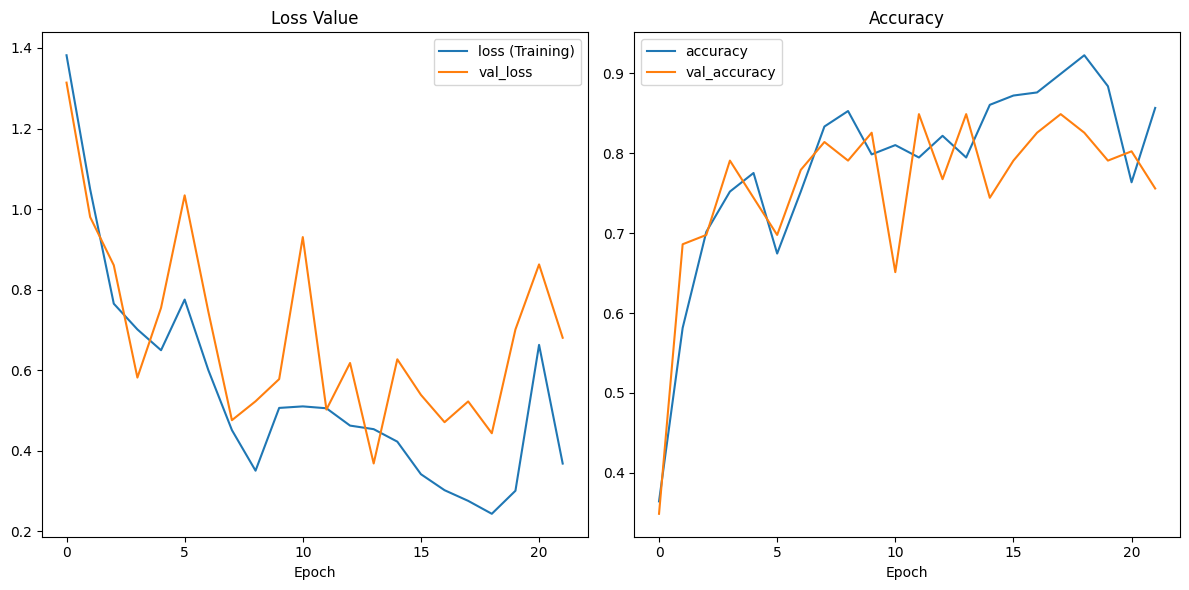

Test loss: 0.33800071477890015
Test accuracy: 0.8604651162790697
F1 Score: 0.8606119904284149
Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.94      0.89        17
         1.0       1.00      0.92      0.96        25
         2.0       0.75      0.78      0.77        23
         3.0       0.85      0.81      0.83        21

    accuracy                           0.86        86
   macro avg       0.86      0.86      0.86        86
weighted avg       0.87      0.86      0.86        86



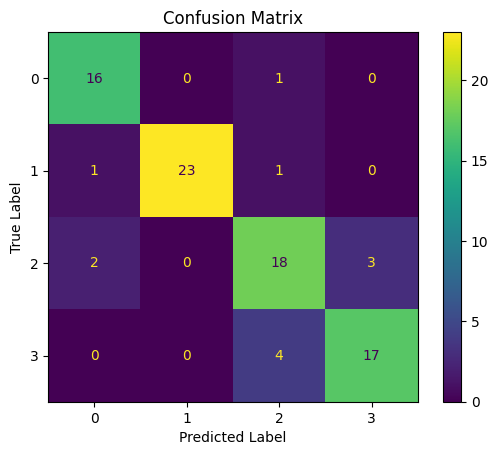

In [13]:
def build_branched_model(input_shape1, input_shape2, input_shape3, input_shape4):
    # First input branch
    input1 = Input(shape=input_shape1, name='input1')
    x1 = Conv1D(filters=128, kernel_size=40, strides=20, activation='relu', padding='same', name='conv1d_1_1')(input1)
    x1 = MaxPooling1D(pool_size=2, name='maxpool1d_1_1')(x1)
    x1 = Conv1D(filters=256, kernel_size=8, strides=4, activation='relu', name='conv1d_1_2')(x1)
    x1 = Dropout(rate=0.2, name='dropout_1_1')(x1)
    x1 = Conv1D(filters=256, kernel_size=2, strides=1, activation='relu', name='conv1d_1_3')(x1)
    x1 = GlobalMaxPooling1D(name='gap1d_1_1')(x1)
    
    # Second input branch
    input2 = Input(shape=input_shape2, name='input2')
    x2 = Conv1D(filters=128, kernel_size=40, strides=20, activation='relu', padding='same', name='conv1d_2_1')(input2)
    x2 = MaxPooling1D(pool_size=2, name='maxpool1d_2_1')(x2)
    x2 = Conv1D(filters=256, kernel_size=8, strides=4, activation='relu', name='conv1d_2_2')(x2)
    x2 = Dropout(rate=0.2, name='dropout_2_1')(x2)
    x2 = Conv1D(filters=64, kernel_size=2, strides=1, activation='relu', name='conv1d_2_3')(x2)
    x2 = GlobalMaxPooling1D(name='gap1d_2_1')(x2)
    
    # Third input branch
    input3 = Input(shape=input_shape3, name='input3')
    x3 = Conv1D(filters=128, kernel_size=40, strides=20, activation='relu', padding='same', name='conv1d_3_1')(input3)
    x3 = MaxPooling1D(pool_size=2, name='maxpool1d_3_1')(x3)
    x3 = Conv1D(filters=256, kernel_size=8, strides=4, activation='relu', name='conv1d_3_2')(x3)
    x3 = Dropout(rate=0.2, name='dropout_3_1')(x3)
    x3 = Conv1D(filters=256, kernel_size=2, strides=1, activation='relu', name='conv1d_3_3')(x3)
    x3 = GlobalMaxPooling1D(name='gap1d_3_1')(x3)
    
    # Fourth input branch
    input4 = Input(shape=input_shape4, name='input4')
    x4 = Conv1D(filters=128, kernel_size=40, strides=20, activation='relu', padding='same', name='conv1d_4_1')(input4)
    x4 = MaxPooling1D(pool_size=2, name='maxpool1d_4_1')(x4)
    x4 = Conv1D(filters=256, kernel_size=8, strides=4, activation='relu', name='conv1d_4_2')(x4)
    x4 = Dropout(rate=0.2, name='dropout_4_1')(x4)
    x4 = Conv1D(filters=64, kernel_size=2, strides=1, activation='relu', name='conv1d_4_3')(x4)
    x4 = GlobalMaxPooling1D(name='gap1d_4_1')(x4)
    
    # Concatenate the outputs of the four branches
    merged = concatenate([x1, x2, x3, x4], name='concatenate_1')
    
    # Dense layers
    dense = Dense(64, activation='relu', name='dense_1')(merged)
    #dense = Dense(32, activation='relu', name='dense_2')(dense)
    
    # Output layer for 4-class classification
    output = Dense(OUT_N, activation='softmax', name='output')(dense)
    
    model = Model(inputs=[input1, input2, input3, input4], outputs=output)
    return model

# Create and compile the model
model = build_branched_model(input_shape1, input_shape2, input_shape3, input_shape4)
model.summary()

X_train = [X_train1, X_train2, X_train3, X_train4]
X_val   = [X_val1, X_val2, X_val3, X_val4]
X_test  = [X_test1, X_test2, X_test3, X_test4]

history, loss, accuracy, f1, y_pred_labels = compile_train_evaluate_plot(model, X_train, y_train, X_val, y_val, X_test, y_test, epochs=70, batch_size=32, patience=8, disp_labels=DISP_LABELS)

In [14]:
# model_name = "MOD_AUG_KNOB_3Cnv_128Dens_400WideKern_96"
# save_datasummary_and_results(model, history, loss, accuracy, f1, model_name, y_test, y_pred_labels, build_branched_model, assign_and_deploy_variables)
# #model.save(f"{model_name}.h5")
# from tensorflow.keras.models import save_model
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

# 4 ConvLayers

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input1 (InputLayer) │ (None, 3000, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input2 (InputLayer) │ (None, 3000, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input3 (InputLayer) │ (None, 3000, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input4 (InputLayer) │ (None, 3000, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_0 (Conv1D) │ (None, 150, 128)  │     12,928 │ input1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_0 (Conv1D) │ (None, 150, 128)  │     12,928 │ input2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_0 (Conv1D) │ (None, 150, 128)  │     25,728 │ input3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_0 (Conv1D) │ (None, 150, 128)  │     25,728 │ input4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_1 (Conv1D) │ (None, 17, 256)   │    655,616 │ conv1d_1_0[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_1 (Conv1D) │ (None, 17, 256)   │    655,616 │ conv1d_2_0[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_1 (Conv1D) │ (None, 17, 256)   │    655,616 │ conv1d_3_0[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_1 (Conv1D) │ (None, 17, 256)   │    655,616 │ conv1d_4_0[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_2 (Conv1D) │ (None, 5, 512)    │  1,049,088 │ conv1d_1_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_2 (Conv1D) │ (None, 5, 256)    │    524,544 │ conv1d_2_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_2 (Conv1D) │ (None, 5, 512)    │  1,049,088 │ conv1d_3_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_2 (Conv1D) │ (None, 5, 256)    │    524,544 │ conv1d_4_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1_1         │ (None, 5, 512)    │          0 │ conv1d_1_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2_1         │ (None, 5, 256)    │          0 │ conv1d_2_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3_1         │ (None, 5, 512)    │          0 │ conv1d_3_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4_1         │ (None, 5, 256)    │          0 │ conv1d_4_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_3 (Conv1D) │ (None, 4, 512)    │    524,800 │ dropout_1_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_3 (Conv1D) │ (None, 4, 128)    │     65,664 │ dropout_2_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_3 (Conv1D) │ (None, 4, 512)    │    524,800 │ dropout_3_1[0][0

 Total params: 7,110,342 (27.12 MB)

 Trainable params: 7,110,342 (27.12 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 571ms/step - accuracy: 0.3112 - loss: 1.4698 - val_accuracy: 0.6163 - val_loss: 1.3300
Epoch 2/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6163 - loss: 1.2875 - val_accuracy: 0.6163 - val_loss: 0.7675
Epoch 3/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7885 - loss: 0.5663 - val_accuracy: 0.6395 - val_loss: 0.7813
Epoch 4/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6719 - loss: 0.8182 - val_accuracy: 0.7791 - val_loss: 0.5124
Epoch 5/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8163 - loss: 0.4377 - val_accuracy: 0.8023 - val_loss: 0.4204
Epoch 6/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8448 - loss: 0.3633 - val_accuracy: 0.8023 - val_loss: 0.4155
Epoch 7/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8358 - loss: 0.3393 - val_accuracy: 0.7442 - val_loss: 0.8631
Epoch 8/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8106 - loss: 0.4549 - val_accuracy: 0.7791 - val_loss: 0.4842
Epoch

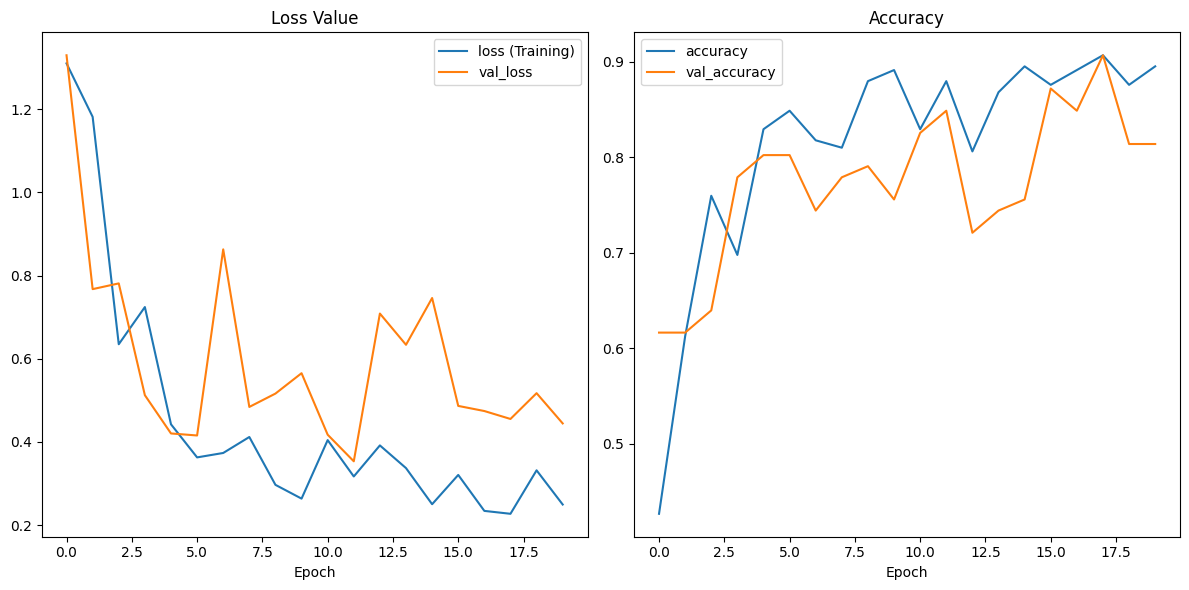

Test loss: 0.2717305123806
Test accuracy: 0.8604651162790697
F1 Score: 0.8584373143196673
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.94      0.97        17
         1.0       0.96      1.00      0.98        25
         2.0       0.68      0.91      0.78        23
         3.0       0.92      0.57      0.71        21

    accuracy                           0.86        86
   macro avg       0.89      0.86      0.86        86
weighted avg       0.88      0.86      0.86        86



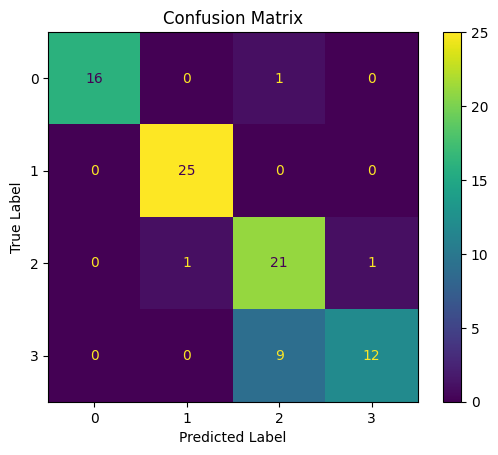

In [15]:
FILTN = 2
def build_branched_model(input_shape1, input_shape2, input_shape3, input_shape4):
    # First input branch
    input1 = Input(shape=input_shape1, name='input1')
    x1 = Conv1D(filters=64*FILTN, kernel_size=100, strides=20, activation='relu', padding='same', name='conv1d_1_0')(input1)
    x1 = Conv1D(filters=128*FILTN, kernel_size=20, strides=8, activation='relu', name='conv1d_1_1')(x1)
    x1 = Conv1D(filters=256*FILTN, kernel_size=8, strides=2, activation='relu', name='conv1d_1_2')(x1)
    x1 = Dropout(rate=0.2, name='dropout_1_1')(x1)
    x1 = Conv1D(filters=256*FILTN, kernel_size=2, strides=1, activation='relu', name='conv1d_1_3')(x1)
    x1 = GlobalMaxPooling1D(name='gap1d_1_1')(x1)

    # Second input branch
    input2 = Input(shape=input_shape2, name='input2')
    x2 = Conv1D(filters=64*FILTN, kernel_size=100, strides=20, activation='relu', padding='same', name='conv1d_2_0')(input2)
    x2 = Conv1D(filters=128*FILTN, kernel_size=20, strides=8, activation='relu', name='conv1d_2_1')(x2)
    x2 = Conv1D(filters=128*FILTN, kernel_size=8, strides=2, activation='relu', name='conv1d_2_2')(x2)
    x2 = Dropout(rate=0.2, name='dropout_2_1')(x2)
    x2 = Conv1D(filters=64*FILTN, kernel_size=2, strides=1, activation='relu', name='conv1d_2_3')(x2)
    x2 = GlobalMaxPooling1D(name='gap1d_2_1')(x2)

    # Third input branch
    input3 = Input(shape=input_shape3, name='input3')
    x3 = Conv1D(filters=64*FILTN, kernel_size=100, strides=20, activation='relu', padding='same', name='conv1d_3_0')(input3)
    x3 = Conv1D(filters=128*FILTN, kernel_size=20, strides=8, activation='relu', name='conv1d_3_1')(x3)
    x3 = Conv1D(filters=256*FILTN, kernel_size=8, strides=2, activation='relu', name='conv1d_3_2')(x3)
    x3 = Dropout(rate=0.2, name='dropout_3_1')(x3)
    x3 = Conv1D(filters=256*FILTN, kernel_size=2, strides=1, activation='relu', name='conv1d_3_3')(x3)
    x3 = GlobalMaxPooling1D(name='gap1d_3_1')(x3)

    # Fourth input branch
    input4 = Input(shape=input_shape4, name='input4')
    x4 = Conv1D(filters=64*FILTN, kernel_size=100, strides=20, activation='relu', padding='same', name='conv1d_4_0')(input4)
    x4 = Conv1D(filters=128*FILTN, kernel_size=20, strides=8, activation='relu', name='conv1d_4_1')(x4)
    x4 = Conv1D(filters=128*FILTN, kernel_size=8, strides=2, activation='relu', name='conv1d_4_2')(x4)
    x4 = Dropout(rate=0.2, name='dropout_4_1')(x4)
    x4 = Conv1D(filters=64*FILTN, kernel_size=2, strides=1, activation='relu', name='conv1d_4_3')(x4)
    x4 = GlobalMaxPooling1D(name='gap1d_4_1')(x4)

    # Concatenate the outputs of the four branches
    merged = concatenate([x1, x2, x3, x4], name='concatenate_1')

    # Dense layers
    dense = Dense(64, activation='relu', name='dense_1')(merged)
    #dense = Dense(16, activation='relu', name='dense_2')(dense)

    # Output layer for 6-class classification
    output = Dense(6, activation='softmax', name='output')(dense)

    # Create the model
    model = Model(inputs=[input1, input2, input3, input4], outputs=output)

    return model

# Create and compile the model
model = build_branched_model(input_shape1, input_shape2, input_shape3, input_shape4)
model.summary()

X_train = [X_train1, X_train2, X_train3, X_train4]
X_val   = [X_val1, X_val2, X_val3, X_val4]
X_test  = [X_test1, X_test2, X_test3, X_test4]

history, loss, accuracy, f1, y_pred_labels = compile_train_evaluate_plot(model, X_train, y_train, X_val, y_val, X_test, y_test, epochs=70, batch_size=32, patience=8, disp_labels=DISP_LABELS)

In [16]:
# model_name = "1D_LD_4Cnv_1Dens_100W_20S_97"
# save_datasummary_and_results(model, history, loss, accuracy, f1, model_name, y_test, y_pred_labels, build_branched_model, assign_and_deploy_variables)
# #model.save(f"{model_name}.h5")
# from tensorflow.keras.models import save_model
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

y_pred: 2


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


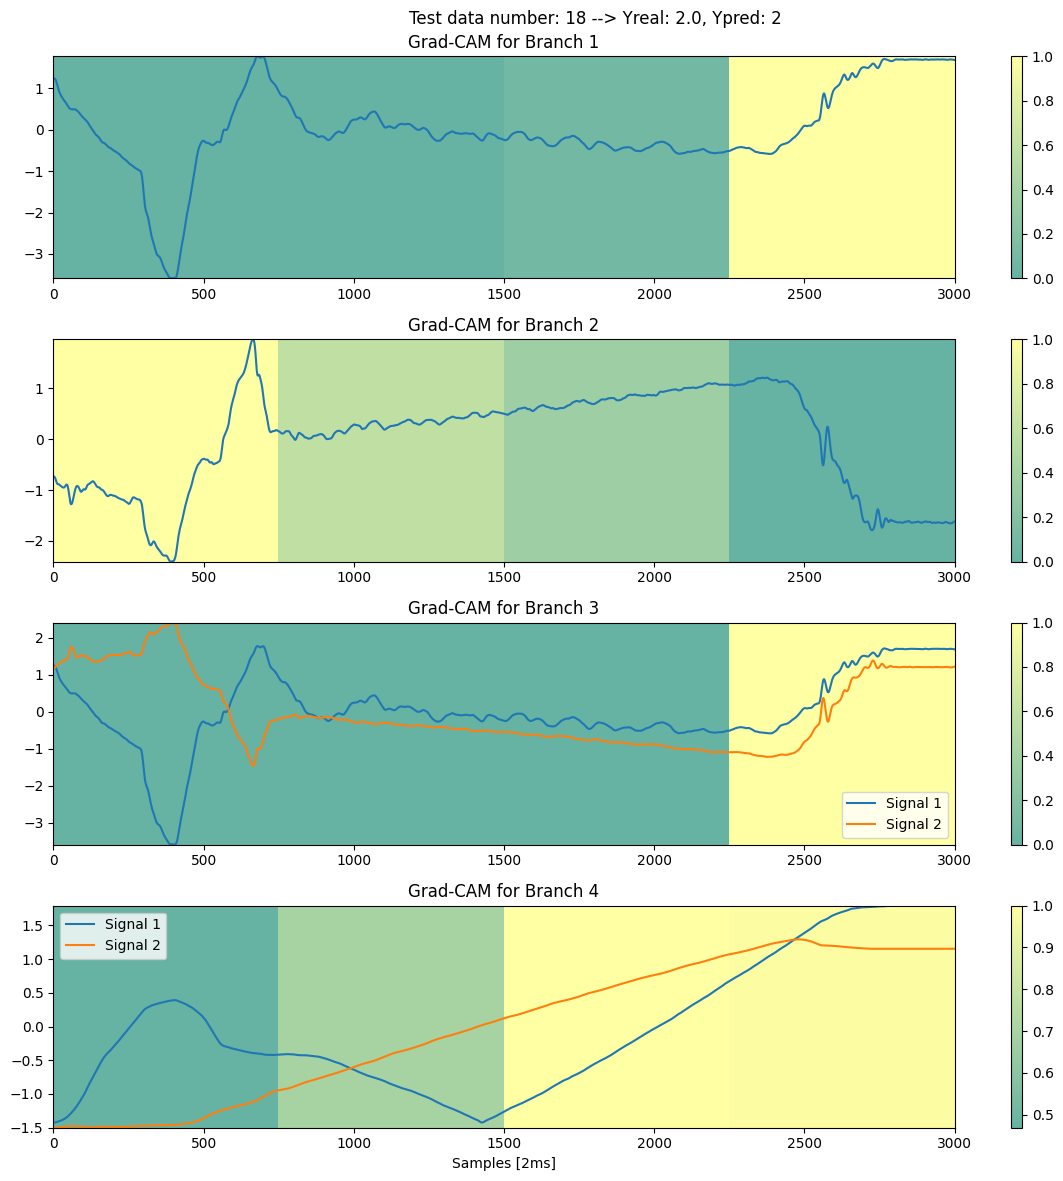

In [17]:
print(f"y_pred: {y_pred_labels[18]}")
plot_grad_cam(model, [X_test1, X_test2, X_test3, X_test4], 18, y_test, ['conv1d_1_3', 'conv1d_2_3', 'conv1d_3_3', 'conv1d_4_3'])

# same as best EASY f+f but branched

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input1 (InputLayer) │ (None, 3000, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input2 (InputLayer) │ (None, 3000, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input3 (InputLayer) │ (None, 3000, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input4 (InputLayer) │ (None, 3000, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_1 (Conv1D) │ (None, 746, 64)   │      1,344 │ input1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_1 (Conv1D) │ (None, 746, 64)   │      1,344 │ input2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_1 (Conv1D) │ (None, 746, 64)   │      2,624 │ input3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_1 (Conv1D) │ (None, 746, 64)   │      2,624 │ input4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 373, 64)   │          0 │ conv1d_1_1[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 373, 64)   │          0 │ conv1d_2_1[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 373, 64)   │          0 │ conv1d_3_1[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 373, 64)   │          0 │ conv1d_4_1[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_2 (Conv1D) │ (None, 90, 128)   │    131,200 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_2 (Conv1D) │ (None, 90, 128)   │    131,200 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_2 (Conv1D) │ (None, 90, 128)   │    131,200 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_2 (Conv1D) │ (None, 90, 128)   │    131,200 │ max_pooling1d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 90, 128)   │          0 │ conv1d_1_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 90, 128)   │          0 │ conv1d_2_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 90, 128)   │          0 │ conv1d_3_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 90, 128)   │          0 │ conv1d_4_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_3 (Conv1D) │ (None, 83, 128)   │    131,200 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_3 (Conv1D) │ (None, 83, 128)   │    131,200 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_3 (Conv1D) │ (None, 83, 128)   │    131,200 │ dropout_2[0][0] 

 Total params: 1,427,140 (5.44 MB)

 Trainable params: 1,427,140 (5.44 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70


9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 501ms/step - accuracy: 0.4419 - loss: 1.3146 - val_accuracy: 0.3953 - val_loss: 1.4595
Epoch 2/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5363 - loss: 1.1602 - val_accuracy: 0.5349 - val_loss: 1.0266
Epoch 3/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6016 - loss: 0.8502 - val_accuracy: 0.5233 - val_loss: 0.9555
Epoch 4/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5505 - loss: 0.9534 - val_accuracy: 0.6395 - val_loss: 0.8453
Epoch 5/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6937 - loss: 0.7421 - val_accuracy: 0.6977 - val_loss: 0.7354
Epoch 6/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7572 - loss: 0.6298 - val_accuracy: 0.7442 - val_loss: 0.6993
Epoch 7/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8006 - loss: 0.4861 - val_accuracy: 0.7442 - val_loss: 0.7404
Epoch 8/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8306 - loss: 0.4083 - val_accuracy: 0.7326 - val_loss: 0.8497
Epoch 9/70
9/9 ━━

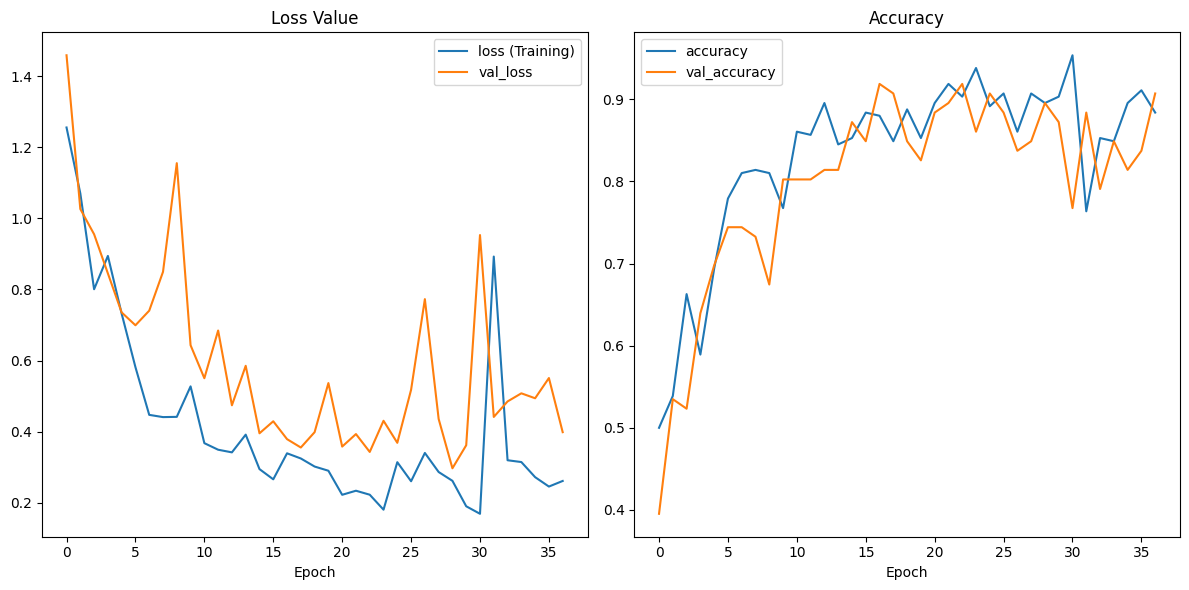

Test loss: 0.21820621192455292
Test accuracy: 0.9418604651162791
F1 Score: 0.9427813083275269
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.94      0.97        17
         1.0       0.96      1.00      0.98        25
         2.0       0.85      0.96      0.90        23
         3.0       1.00      0.86      0.92        21

    accuracy                           0.94        86
   macro avg       0.95      0.94      0.94        86
weighted avg       0.95      0.94      0.94        86



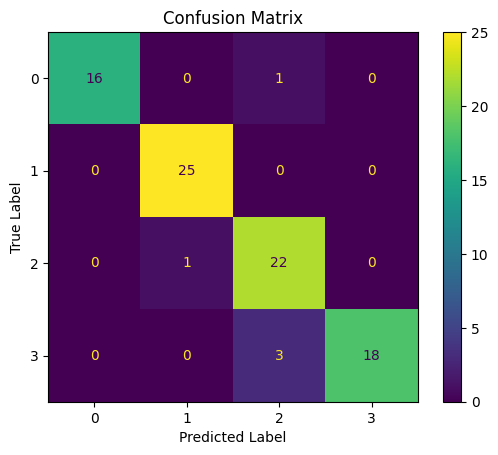

In [18]:
def build_branched_model(input_shape1, input_shape2, input_shape3, input_shape4):
    # First input branch
    input1 = Input(shape=input_shape1, name='input1')
    x1 = Conv1D(filters=64, kernel_size=20, strides=4, activation='relu', name='conv1d_1_1')(input1)
    x1 = MaxPooling1D(pool_size=2)(x1)
    x1 = Conv1D(filters=128, kernel_size=16, strides=4, activation='relu', name='conv1d_1_2')(x1)
    x1 = Dropout(rate=0.1)(x1)
    x1 = Conv1D(filters=128, kernel_size=8, activation='relu', name='conv1d_1_3')(x1)
    x1 = MaxPooling1D(pool_size=2)(x1)
    x1 = Conv1D(filters=256, kernel_size=4, activation='relu', name='conv1d_1_4')(x1)
    x1 = GlobalMaxPooling1D(name='gap1d_1_1')(x1)
    
    # Second input branch
    input2 = Input(shape=input_shape2, name='input2')
    x2 = Conv1D(filters=64, kernel_size=20, strides=4, activation='relu', name='conv1d_2_1')(input2)
    x2 = MaxPooling1D(pool_size=2)(x2)
    x2 = Conv1D(filters=128, kernel_size=16, strides=4, activation='relu', name='conv1d_2_2')(x2)
    x2 = Dropout(rate=0.1)(x2)
    x2 = Conv1D(filters=128, kernel_size=8, activation='relu', name='conv1d_2_3')(x2)
    x2 = MaxPooling1D(pool_size=2)(x2)
    x2 = Conv1D(filters=64, kernel_size=4, activation='relu', name='conv1d_2_4')(x2)
    x2 = GlobalMaxPooling1D(name='gap1d_2_1')(x2)
    
    # Third input branch
    input3 = Input(shape=input_shape3, name='input3')
    x3 = Conv1D(filters=64, kernel_size=20, strides=4, activation='relu', name='conv1d_3_1')(input3)
    x3 = MaxPooling1D(pool_size=2)(x3)
    x3 = Conv1D(filters=128, kernel_size=16, strides=4, activation='relu', name='conv1d_3_2')(x3)
    x3 = Dropout(rate=0.1)(x3)
    x3 = Conv1D(filters=128, kernel_size=8, activation='relu', name='conv1d_3_3')(x3)
    x3 = MaxPooling1D(pool_size=2)(x3)
    x3 = Conv1D(filters=256, kernel_size=4, activation='relu', name='conv1d_3_4')(x3)
    x3 = GlobalMaxPooling1D(name='gap1d_3_1')(x3)
    
    # Fourth input branch
    input4 = Input(shape=input_shape4, name='input4')
    x4 = Conv1D(filters=64, kernel_size=20, strides=4, activation='relu', name='conv1d_4_1')(input4)
    x4 = MaxPooling1D(pool_size=2)(x4)
    x4 = Conv1D(filters=128, kernel_size=16, strides=4, activation='relu', name='conv1d_4_2')(x4)
    x4 = Dropout(rate=0.1)(x4)
    x4 = Conv1D(filters=128, kernel_size=8, activation='relu', name='conv1d_4_3')(x4)
    x4 = MaxPooling1D(pool_size=2)(x4)
    x4 = Conv1D(filters=64, kernel_size=4, activation='relu', name='conv1d_4_4')(x4)
    x4 = GlobalMaxPooling1D(name='gap1d_4_1')(x4)
    
    # Concatenate the outputs of the four branches
    merged = concatenate([x1, x2, x3, x4], name='concatenate_1')
    
    # Dense layers
    dense = Dense(64, activation='relu', name='dense_1')(merged)
    #dense = Dense(16, activation='relu', name='dense_2')(dense)
    
    # Output layer for 4-class classification (adjust if needed)
    output = Dense(OUT_N, activation='softmax', name='output')(dense)
    
    model = Model(inputs=[input1, input2, input3, input4], outputs=output)
    return model

# Create and compile the model
model = build_branched_model(input_shape1, input_shape2, input_shape3, input_shape4)
model.summary()

X_train = [X_train1, X_train2, X_train3, X_train4]
X_val   = [X_val1, X_val2, X_val3, X_val4]
X_test  = [X_test1, X_test2, X_test3, X_test4]

history, loss, accuracy, f1, y_pred_labels = compile_train_evaluate_plot(model, X_train, y_train, X_val, y_val, X_test, y_test, epochs=70, batch_size=32, patience=8, disp_labels=DISP_LABELS)

In [19]:
# model_name = "MOD_AUG_KNOB_3Cnv_128Dens_400WideKern_96"
# save_datasummary_and_results(model, history, loss, accuracy, f1, model_name, y_test, y_pred_labels, build_branched_model, assign_and_deploy_variables)
# #model.save(f"{model_name}.h5")
# from tensorflow.keras.models import save_model
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


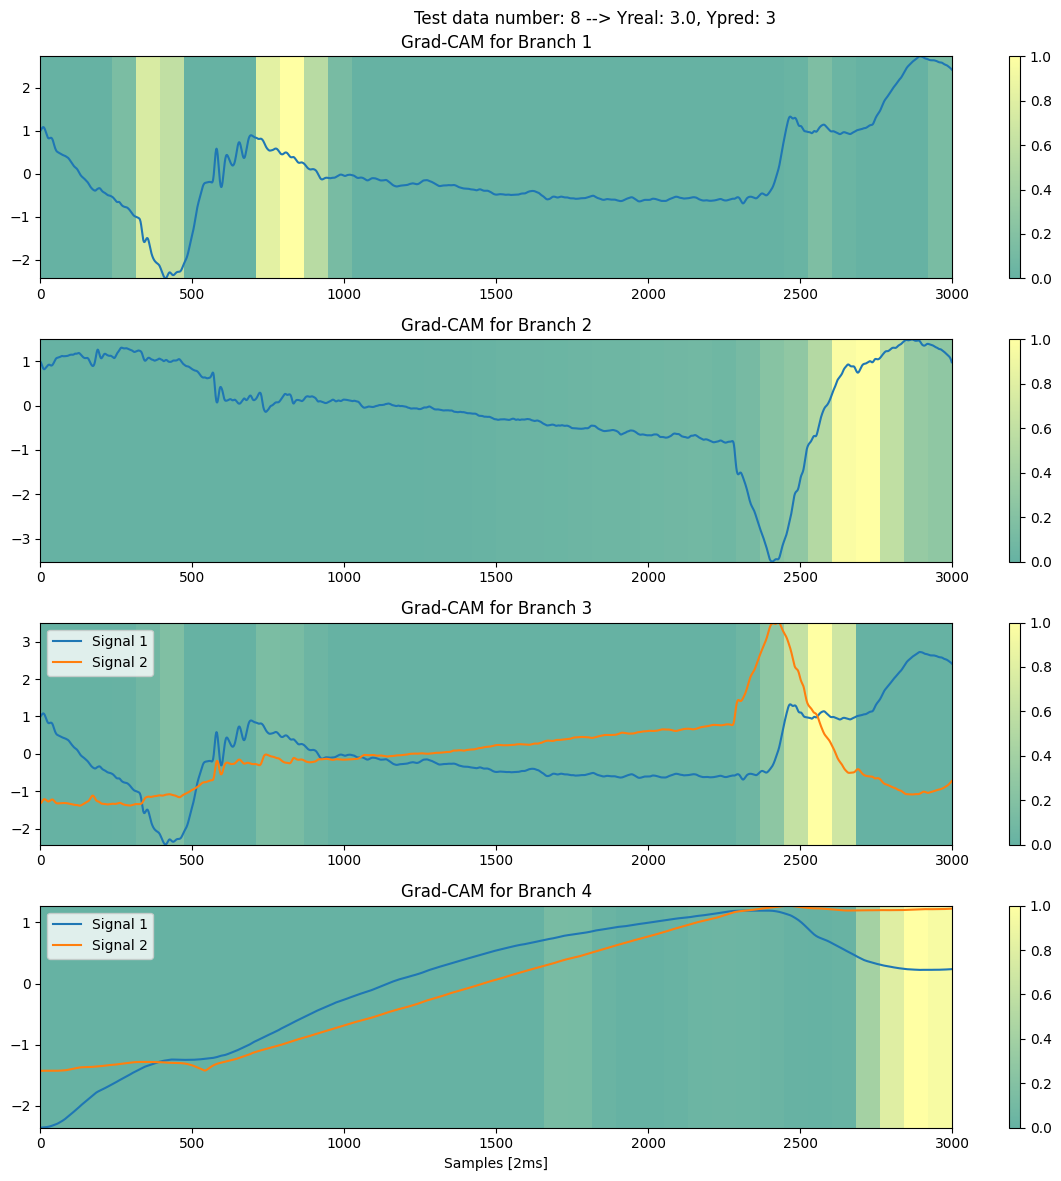

In [20]:
plot_grad_cam(model, [X_test1, X_test2, X_test3, X_test4], 8, y_test, ['conv1d_1_4', 'conv1d_2_4', 'conv1d_3_4', 'conv1d_4_4'])